<a href="https://colab.research.google.com/github/1900690/grape-count/blob/main/realtime-grape-count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab ウェブカメラで画像やビデオにアクセスする
このノートでは、ウェブカメラで撮影した画像やビデオにアクセスしてコードを実行する方法を説明します。
このチュートリアルでは、OpenCVのHaar Cascadeを使って、ウェブカメラの画像や動画から顔を検出します。

In [1]:
#ライブラリをインポート
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

## 関数定義
以下は、異なる画像データ型やフォーマット間の変換を行うための関数です。

In [2]:
# 関数を使用して，JavaScript オブジェクトを OpenCV 画像に変換します。
def js_to_image(js_reply):
  """
  パラメータ
          js_reply： ウェブカメラからの画像を含む JavaScript オブジェクト
  戻り値
          img： OpenCV BGR 画像
  """
  # base64 imageをデコードする
  image_bytes = b64decode(js_reply.split(',')[1])
  # 配列をnumpy配列に変換する
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # numpy配列をOpenCV BGR画像にデコードする
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

#  OpenCVの矩形バウンディングボックス画像をBase64バイト文字列に変換してビデオストリームにオーバーレイする関数
def bbox_to_bytes(bbox_array):
  """
  パラメータ
          bbox_array： ビデオストリームにオーバーレイする矩形を含む Numpy 配列 (ピクセル)。
  戻り値
        バイト数： Base64 画像バイト列
  """
  # 配列をPIL画像に変換
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # bboxをpngに整形して返す
  bbox_PIL.save(iobuf, format='png')
  # フォーマットの戻り文字列
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Haar Cascade分類器
このチュートリアルでは、Haar Cascadeと呼ばれるシンプルなオブジェクト検出アルゴリズムを、ウェブカメラから取得した画像とビデオに対して実行します。OpenCVには、事前にトレーニングされたHaar Cascade顔検出モデルがあります。

In [3]:
# Haar Cascade顔検出モデルを初期化する。
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## ウェブカメラ画像
ウェブカメラで撮影した画像に対してコードを実行するのは、かなり簡単です。Google ColabのCode Snippetsには、様々なタスクを実行するための便利なコード関数が用意されています。
今回は、Camera Captureのコード・スニペットを使って、コンピュータのウェブカメラを利用します。

In [8]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // ビデオ・エレメントに合わせて出力のサイズを変更する。
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Captureがクリックされるのを待つ。
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # 写真データを取得する
  data = eval_js('takePhoto({})'.format(quality))
  # OpenCV形式の画像を取得する
  img = js_to_image(data)
  # グレースケール画像
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # Haar Cascadeを使って顔のバウンディングボックス座標を取得する
  faces = face_cascade.detectMultiScale(gray)
  # 画像に顔のバウンディングボックスを描く
  for count,(x,y,w,h) in enumerate(faces, start=1):
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  print('bbox count to ',count)
  print('faces to ',faces)
  # 画像を保存
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
bbox count to  1
faces to  [[239 174 206 206]]
Saved to photo.jpg


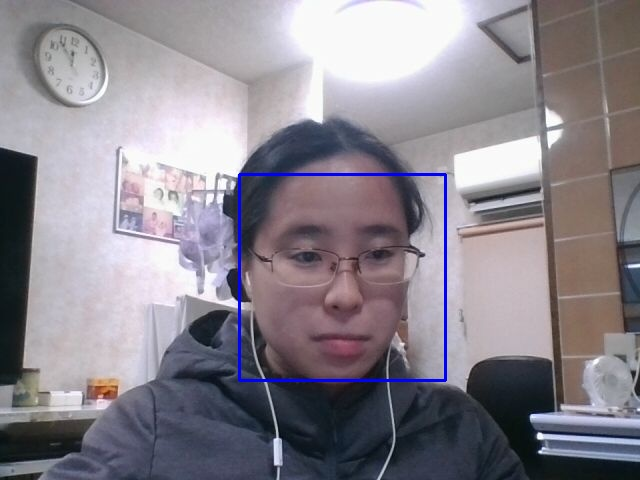

In [42]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # 撮影したばかりの画像を表示する。
  display(Image(filename))
except Exception as err:
  # ユーザーがウェブカメラを持っていないか、ページにアクセス許可を与えていない場合は、エラーがスローされます。
  print(str(err))

## ウェブカメラ
ウェブカメラのビデオでコードを実行するのは、画像よりも少し複雑だ。ウェブカメラを入力としてビデオストリームを開始する必要がある。次に、各フレームをプログラム（顔検出）に通し、検出のバウンディングボックスを含むオーバーレイ画像を作成する。次に、バウンディングボックス画像をビデオストリームの次のフレームにオーバーレイします。

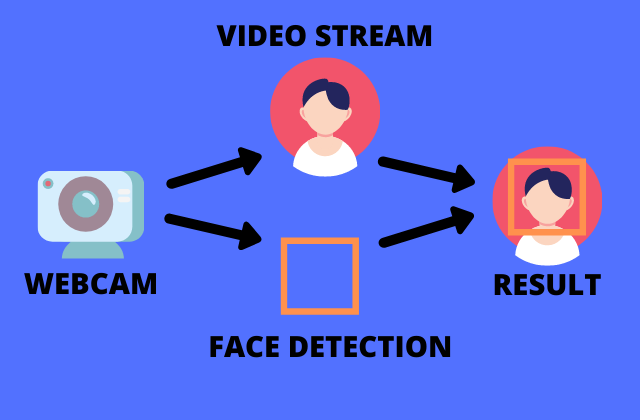</center>

In [7]:
# ウェブカメラを入力としてライブ・ビデオ・ストリームを適切に作成するためのJavaScript
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [60]:
# ウェブカメラからのビデオストリーミング開始
video_stream()
# ビデオ用ラベル
label_html = 'Capturing...'
# バウンディングボックスを空に初期化する
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # JSレスポンスをOpenCV画像に変換
    img = js_to_image(js_reply["img"])

    # バウンディング・ボックスに透明オーバーレイを作成する
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    #  顔検出用グレースケール画像
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 顔領域の座標を取得する
    faces = face_cascade.detectMultiScale(gray)

    #★検出
    annotator = Annotator(img, example=model.names)

    # オーバーレイの顔境界ボックスを取得
    for count,(x,y,w,h) in enumerate(faces, start=1):
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array=cv2.putText(bbox_array, str(count), (550, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,0,0), thickness=2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    #  bboxのオーバーレイをバイトに変換
    bbox_bytes = bbox_to_bytes(bbox_array)
    #  次のフレームに新しいオーバーレイが表示されるように、bboxを更新する。
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [43]:
#yoloの設定
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


In [61]:
import cv2

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

model = YOLO("yolo11n.pt")  # Load pretrain or fine-tune model

# Process the image
source = cv2.imread("/content/photo.jpg")
#results = model(source)

# Extract results
annotator = Annotator(source, example=model.names)

for count,box in enumerate(results[0].boxes.xyxy.cpu(), start=1):
    width, height, area = annotator.get_bbox_dimension(box)
    print(f"Bounding Box Width {int(width.item())}, Height {int(height.item())}, Area {int(area.item())}")
print(count)

Bounding Box Width 484, Height 365, Area 176874
Bounding Box Width 76, Height 84, Area 6501
Bounding Box Width 37, Height 238, Area 8876
Bounding Box Width 90, Height 124, Area 11291
Bounding Box Width 174, Height 123, Area 21639
Bounding Box Width 28, Height 39, Area 1105
Bounding Box Width 35, Height 29, Area 1018
7


In [62]:
results[0].boxes.xyxy.cpu()

tensor([[4.1906e+01, 1.1382e+02, 5.2641e+02, 4.7889e+02],
        [3.1997e+01, 2.2863e+01, 1.0877e+02, 1.0755e+02],
        [1.7394e-01, 1.4811e+02, 3.7353e+01, 3.8687e+02],
        [4.6564e+02, 3.5530e+02, 5.5660e+02, 4.7944e+02],
        [4.6457e+02, 3.5580e+02, 6.3919e+02, 4.7972e+02],
        [1.2961e+01, 3.6833e+02, 4.1216e+01, 4.0744e+02],
        [8.5346e+01, 3.7605e+02, 1.2047e+02, 4.0506e+02]])